In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=[]#2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=[]#2


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display

In [5]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [6]:
all_x = np.load(DATA_DIR / 'starling_128_numpy' / 'all_specs.npy')

In [7]:
x1, x2, x3 = np.load(DATA_DIR / 'starling_128_numpy' / 'j-points.npy')

In [8]:
np.shape(all_x)

(91648, 128, 128)

### PCA

In [9]:
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

In [10]:
# umap
specs_flattened = flatten_spectrograms(all_x)#[:, :10]#[:20000]

In [11]:
np.shape(specs_flattened)

(91648, 16384)

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=128)

In [14]:
pca.fit(specs_flattened)

PCA(copy=True, iterated_power='auto', n_components=128, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
zpca = pca.transform(specs_flattened)

In [16]:
proj = pca.inverse_transform(zpca[0])

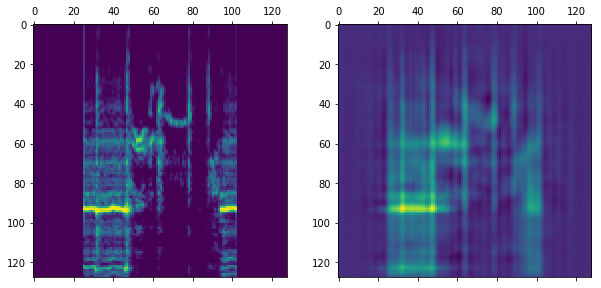

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].matshow(specs_flattened[0].reshape((128,128)))
axs[1].matshow(proj.reshape((128,128)))

In [19]:
pt1, pt2, pt3 = pca.transform(flatten_spectrograms(np.array([x1*255, x2*255, x3*255]).astype('uint8')))

In [21]:
interp_len = 5

In [24]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = pca.inverse_transform(z_list)

In [25]:
np.shape(x_list)

(25, 16384)

In [56]:
x_list = x_list.reshape(len(x_list), 128, 128, 1)

In [30]:
np.max(x_list)

283.8198540723506

In [62]:
# make diagram
Jdiagram = np.ones((x_list.shape[1] * (interp_len),
                    x_list.shape[2] * (interp_len + 2), x_list.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len - 1 - bi) * x_list.shape[1]:((interp_len - bi)) *
                 x_list.shape[1], (ci + 1) * x_list.shape[2]:(ci + 2) *
                 x_list.shape[2], :] = x_list[i]  / 255
        i += 1
Jdiagram[(interp_len - 1) * x_list.shape[1]:(interp_len) *
         x_list.shape[1], :x_list.shape[2], :] = x3 

Jdiagram[(interp_len - 1) * x_list.shape[1]:(interp_len) *
         x_list.shape[1], (interp_len + 1) * x_list.shape[2]:(interp_len + 2) *
         x_list.shape[2], :] = x1 
Jdiagram[:x_list.shape[1], :x_list.shape[2], :] = x2

In [67]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

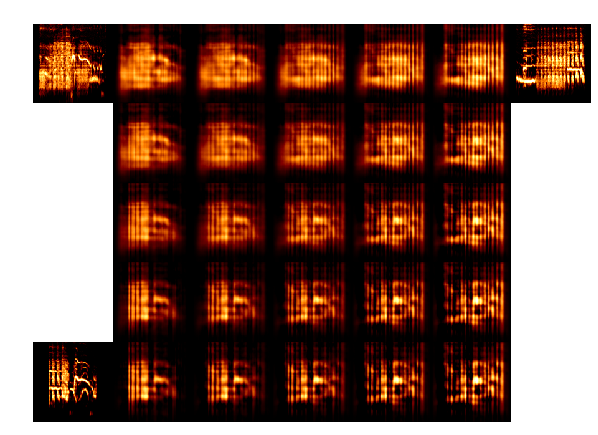

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, vmax = 1, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('PCA_JDIAGRAM_128'), dpi=300, save_jpg=True)